<a href="https://colab.research.google.com/github/vinits7/ML-Projects/blob/main/StockMarketPredictionUsingNumericalandTextualAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author - Vinit Shah

Stock Market Prediction using Numerical and Textual Analysis

Create a hybrid model for stock price or performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines. The stock to analyze and predict is SENSEX (S&P BSE SENSEX)

Stock Market Prediction using Numerical and Textual Analysis
● Objective: Create a hybrid model for stock price/performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines

● Stock to analyze and predict - SENSEX (S&P BSE SENSEX)

● Download historical stock prices from finance.yahoo.com

I have used Auto-ARIMA model to make stock market prices predictions using the historical stock prices data. In the sentiment analysis model, I have made use of different machine learning algorithms-Random Forest Regressor, LightGBM, Adaboost and Xgboost- to make the predictions.

In [1]:
from google.colab import files 
uploaded = files.upload()

Saving ^BSESN.csv to ^BSESN.csv


In [2]:


from google.colab import files 
uploaded = files.upload()

Saving india-news-headlines.csv to india-news-headlines.csv


In [3]:
!pip install pmdarima

import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import xgboost 
import lightgbm 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 28.5 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


TIME SERIES ANALYSIS

In [5]:



df_prices = pd.read_csv('/content/^BSESN.csv')
print(df_prices.head())
print(df_prices.size)

         Date          Open          High           Low         Close  \
0  2019-12-17  41052.359375  41401.648438  41005.179688  41352.171875   
1  2019-12-18  41442.750000  41614.769531  41358.468750  41558.570313   
2  2019-12-19  41571.820313  41719.289063  41456.398438  41673.921875   
3  2019-12-20  41746.199219  41809.960938  41636.109375  41681.539063   
4  2019-12-23  41548.261719  41701.621094  41474.609375  41642.660156   

      Adj Close   Volume  
0  41352.171875  19000.0  
1  41558.570313  24300.0  
2  41673.921875  33300.0  
3  41681.539063  33600.0  
4  41642.660156   6200.0  
1764


In [6]:
#Converting Date column to datetime datatype
df_prices['Date'] = pd.to_datetime(df_prices['Date'])
df_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       252 non-null    datetime64[ns]
 1   Open       250 non-null    float64       
 2   High       250 non-null    float64       
 3   Low        250 non-null    float64       
 4   Close      250 non-null    float64       
 5   Adj Close  250 non-null    float64       
 6   Volume     250 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 13.9 KB


In [7]:

df_prices.dropna(inplace = True)

Text(0, 0.5, 'Close')

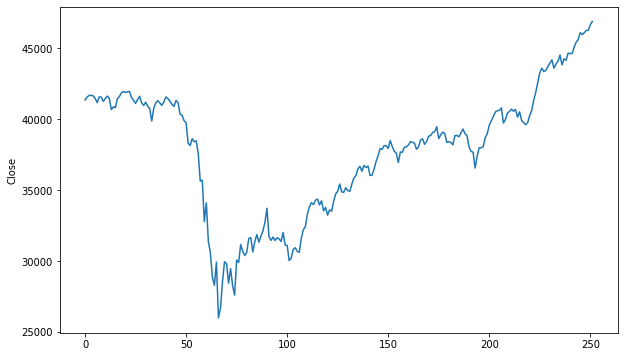

In [8]:
plt.figure(figsize=(10, 6))
df_prices['Close'].plot()
plt.ylabel('Close')


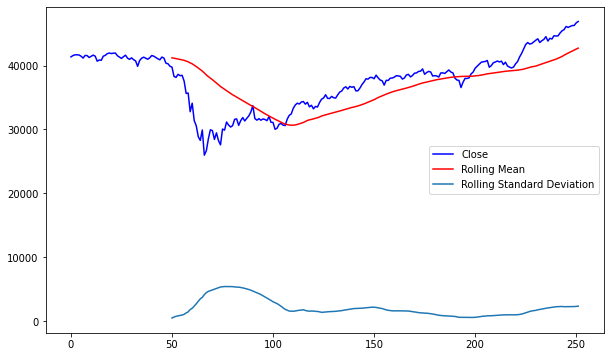

In [9]:
#Plotting moving average
close = df_prices['Close']
ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

plt.figure(figsize=(10, 6))
df_prices['Close'].plot(color = 'b', label = 'Close')
ma.plot(color = 'r', label = 'Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')
plt.legend()

Text(0.5, 1.0, 'Returns')

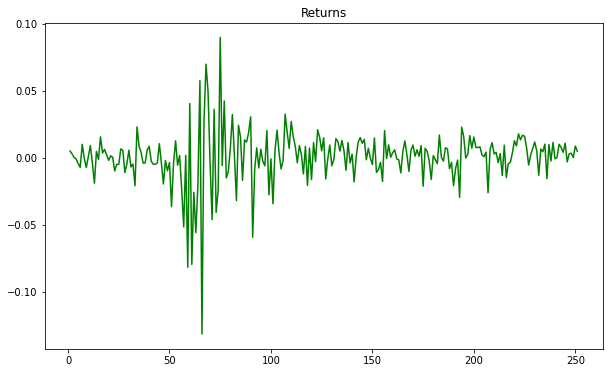

In [10]:
#Plotting returns
returns = close / close.shift(1) - 1

plt.figure(figsize = (10,6))
returns.plot(label='Return', color = 'g')
plt.title("Returns")

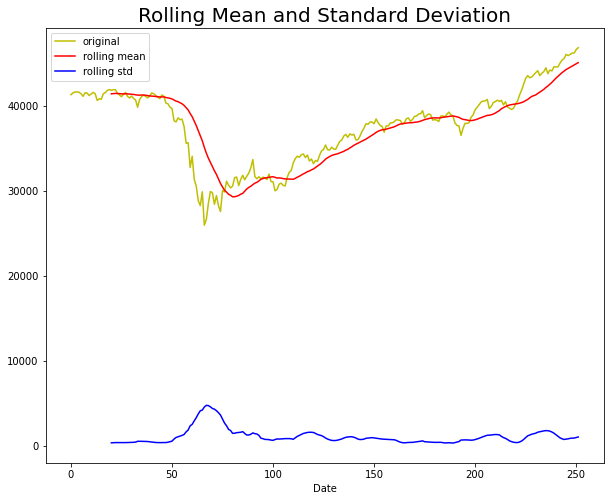

Results of dickey fuller test
ADF Test Statistic : -0.698285082749831
p-value : 0.8471932401708802
#Lags Used : 6
Number of Observations Used : 243
Weak evidence against null hypothesis, time series is non-stationary 


In [11]:
train = df_prices[:1000]
test = df_prices[1000:]#Stationarity test
def test_stationarity(timeseries):

 #Determing rolling statistics
 rolmean = timeseries.rolling(20).mean()
 rolstd = timeseries.rolling(20).std()

 #Plot rolling statistics:
 plt.figure(figsize = (10,8))
 plt.plot(timeseries, color = 'y', label = 'original')
 plt.plot(rolmean, color = 'r', label = 'rolling mean')
 plt.plot(rolstd, color = 'b', label = 'rolling std')
 plt.xlabel('Date')
 plt.legend()
 plt.title('Rolling Mean and Standard Deviation',  fontsize = 20)
 plt.show(block = False)
 
 print('Results of dickey fuller test')
 result = adfuller(timeseries, autolag = 'AIC')
 labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
 for value,label in zip(result, labels):
   print(label+' : '+str(value) )
 if result[1] <= 0.05:
   print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
 else:
   print("Weak evidence against null hypothesis, time series is non-stationary ")
test_stationarity(train['Close'])

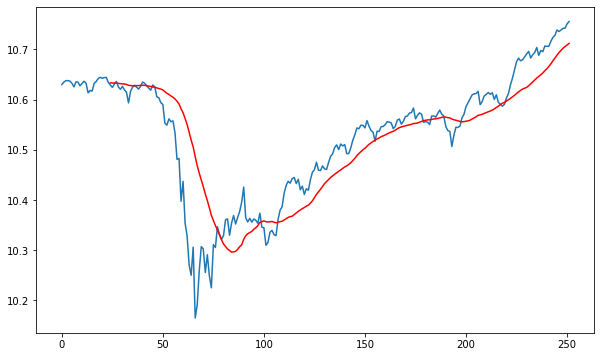

In [12]:
train_log = np.log(train['Close']) 
test_log = np.log(test['Close'])

mav = train_log.rolling(24).mean() 
plt.figure(figsize = (10,6))
plt.plot(train_log) 
plt.plot(mav, color = 'red') 

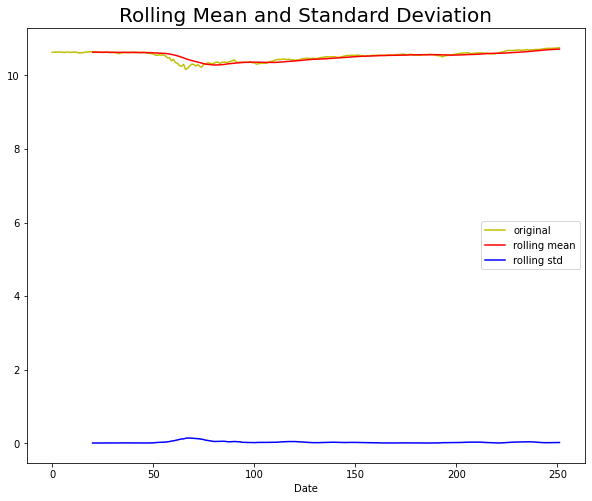

Results of dickey fuller test
ADF Test Statistic : -1.1857021490482853
p-value : 0.6797158478016483
#Lags Used : 7
Number of Observations Used : 242
Weak evidence against null hypothesis, time series is non-stationary 


In [13]:
train_log.dropna(inplace = True)
test_log.dropna(inplace = True)

test_stationarity(train_log)

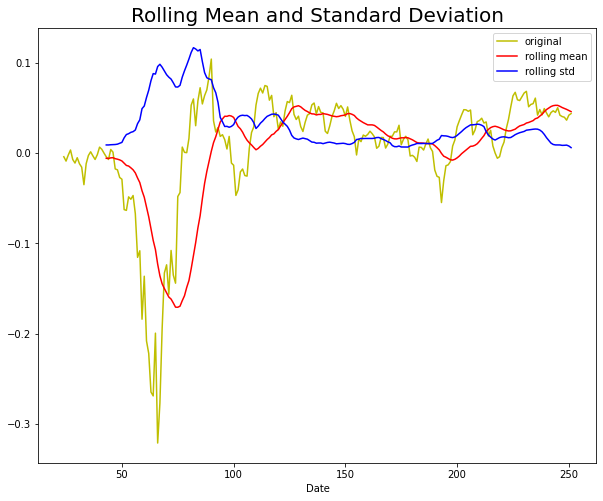

Results of dickey fuller test
ADF Test Statistic : -3.018810804327608
p-value : 0.03317466037433331
#Lags Used : 7
Number of Observations Used : 219
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [14]:
train_log_diff = train_log - mav
train_log_diff.dropna(inplace = True)

test_stationarity(train_log_diff)

In [15]:
#Using auto arima to make predictions using log data
from pmdarima import auto_arima
model = auto_arima(train_log, trace = True, error_action = 'ignore', suppress_warnings = True)
model.fit(train_log)




Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1229.181, Time=0.77 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1228.630, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1231.551, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1230.976, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1230.477, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1230.063, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1229.768, Time=0.57 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1232.318, Time=0.66 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-1228.479, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1233.519, Time=0.76 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1230.635, Time=0.53 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1233.464, Time=1.61 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1231.040, Time=1.36 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-1233.160, Time=0.83 sec
 ARIMA(1,1,2)(0,0,0

ARIMA(order=(1, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

Text(0, 0.5, 'Actual Stock Price')

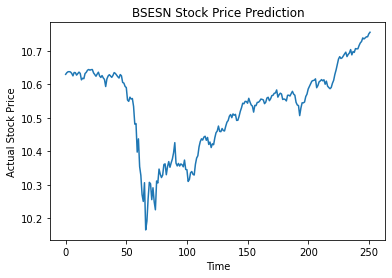

In [26]:
plt.plot(train_log, label='Train')
plt.plot(test_log, label='Test')

plt.title('BSESN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')

TEXTUAL ANALYSIS

In [18]:
cols = ['Date','Category','News']
df_news = pd.read_csv('/content/india-news-headlines.csv', names = cols)
df_news

,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa
...,...,...,...
3650966,20220331,city.srinagar,J&K sacks 2 cops; 3 other employees over terro...
3650967,20220331,entertainment.hindi.bollywood,Ranbir Kapoor says 'Rishi Kapoor enjoyed his a...
3650968,20220331,city.trichy,As Covid-19 cases drop to nil in southern dist...
3650969,20220331,city.erode,Tamil Nadu sees marginal rise of Covid cases w...


In [19]:
df_news.drop(0, inplace=True)
df_news.drop('Category', axis = 1, inplace=True)
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3650970 entries, 1 to 3650970
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Date    object
 1   News    object
dtypes: object(2)
memory usage: 83.6+ MB


In [20]:
#Converting data type of Date column 



import pandas as pd
df_news['Date'] = pd.to_datetime(df_news['Date'],format= '%Y%m%d')
df_news

,Date,News
1,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2,2001-01-02,Fissures in Hurriyat over Pak visit
3,2001-01-02,America's unwanted heading for India?
4,2001-01-02,For bigwigs; it is destination Goa
5,2001-01-02,Extra buses to clear tourist traffic
...,...,...
3650966,2022-03-31,J&K sacks 2 cops; 3 other employees over terro...
3650967,2022-03-31,Ranbir Kapoor says 'Rishi Kapoor enjoyed his a...
3650968,2022-03-31,As Covid-19 cases drop to nil in southern dist...
3650969,2022-03-31,Tamil Nadu sees marginal rise of Covid cases w...


In [28]:
#Grouping the headlines for each day
df_news['News'] = df_news.groupby(['Date']).transform(lambda x : ' '.join(x)) 
df_news = df_news.drop_duplicates() 
df_news.reset_index(inplace = True, drop = True)
df_news

,Date,News
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-03,Powerless north India gropes in the dark Think...
2,2001-01-04,The string that pulled Stephen Hawking to Indi...
3,2001-01-05,Light combat craft takes India into club class...
4,2001-01-06,Light combat craft takes India into club class...
...,...,...
7712,2022-03-27,Playing a dead man in Body God meant sitting i...
7713,2022-03-28,As fashion becomes democratic; demand for styl...
7714,2022-03-29,Bobby Deol: Like my dad; I hope to be working ...
7715,2022-03-30,I will not give in to trends: Dossmode The tim...


In [31]:
df_news['News']

0       Status quo will not be disturbed at Ayodhya; s...
1       Powerless north India gropes in the dark Think...
2       The string that pulled Stephen Hawking to Indi...
3       Light combat craft takes India into club class...
4       Light combat craft takes India into club class...
                              ...                        
7712    Playing a dead man in Body God meant sitting i...
7713    As fashion becomes democratic; demand for styl...
7714    Bobby Deol: Like my dad; I hope to be working ...
7715    I will not give in to trends: Dossmode The tim...
7716    Shashank goes back to coastal Karnataka and Mo...
Name: News, Length: 7717, dtype: object

In [33]:
#Cleaning headlines
c = []
for i in range(0,len(df_news['News'])):
    news = re.sub('[^a-zA-Z]',' ',df_news['News'][i])
    news = news.lower()
    news = news.split()
    news=' '.join(news)
    c.append(news)

In [34]:
df_news['News'] = pd.Series(c)
df_news

,Date,News
0,2001-01-02,status quo will not be disturbed at ayodhya sa...
1,2001-01-03,powerless north india gropes in the dark think...
2,2001-01-04,the string that pulled stephen hawking to indi...
3,2001-01-05,light combat craft takes india into club class...
4,2001-01-06,light combat craft takes india into club class...
...,...,...
7712,2022-03-27,playing a dead man in body god meant sitting i...
7713,2022-03-28,as fashion becomes democratic demand for styli...
7714,2022-03-29,bobby deol like my dad i hope to be working wh...
7715,2022-03-30,i will not give in to trends dossmode the time...


In [35]:
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return  TextBlob(text).sentiment.polarity

In [37]:
#Adding subjectivity and polarity columns
df_news['Subjectivity'] = df_news['News'].apply(getSubjectivity)
df_news['Polarity'] = df_news['News'].apply(getPolarity)
df_news

,Date,News,Subjectivity,Polarity
0,2001-01-02,status quo will not be disturbed at ayodhya sa...,0.286859,0.143590
1,2001-01-03,powerless north india gropes in the dark think...,0.392857,0.089286
2,2001-01-04,the string that pulled stephen hawking to indi...,0.445360,0.093039
3,2001-01-05,light combat craft takes india into club class...,0.480553,0.264024
4,2001-01-06,light combat craft takes india into club class...,0.439394,0.248485
...,...,...,...,...
7712,2022-03-27,playing a dead man in body god meant sitting i...,0.365123,0.034162
7713,2022-03-28,as fashion becomes democratic demand for styli...,0.383007,0.058513
7714,2022-03-29,bobby deol like my dad i hope to be working wh...,0.403627,0.092144
7715,2022-03-30,i will not give in to trends dossmode the time...,0.344136,0.039954


<AxesSubplot:>

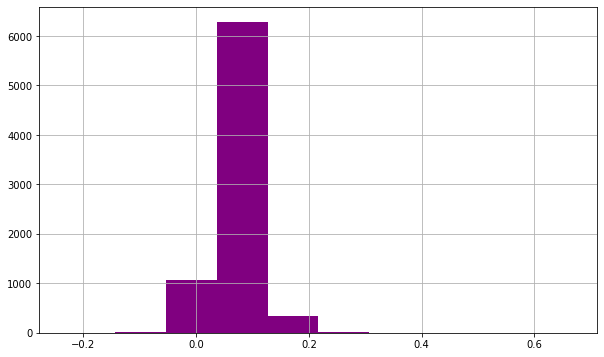

In [38]:
plt.figure(figsize = (10,6))
df_news['Polarity'].hist(color = 'purple')

<AxesSubplot:>

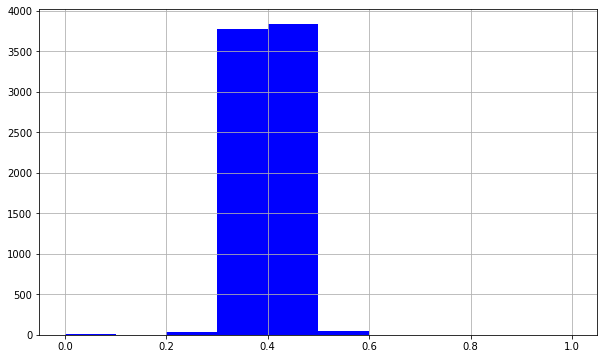

In [39]:
plt.figure(figsize = (10,6))
df_news['Subjectivity'].hist(color = 'blue')

In [40]:
#Adding sentiment score to df_news
sia = SentimentIntensityAnalyzer()

df_news['Compound'] = [sia.polarity_scores(v)['compound'] for v in df_news['News']]
df_news['Negative'] = [sia.polarity_scores(v)['neg'] for v in df_news['News']]
df_news['Neutral'] = [sia.polarity_scores(v)['neu'] for v in df_news['News']]
df_news['Positive'] = [sia.polarity_scores(v)['pos'] for v in df_news['News']]
df_news

,Date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02,status quo will not be disturbed at ayodhya sa...,0.286859,0.143590,-0.9792,0.121,0.809,0.071
1,2001-01-03,powerless north india gropes in the dark think...,0.392857,0.089286,-0.8910,0.156,0.735,0.109
2,2001-01-04,the string that pulled stephen hawking to indi...,0.445360,0.093039,0.7543,0.104,0.792,0.104
3,2001-01-05,light combat craft takes india into club class...,0.480553,0.264024,0.9873,0.138,0.691,0.171
4,2001-01-06,light combat craft takes india into club class...,0.439394,0.248485,-0.8316,0.214,0.655,0.131
...,...,...,...,...,...,...,...,...
7712,2022-03-27,playing a dead man in body god meant sitting i...,0.365123,0.034162,-0.9999,0.160,0.758,0.082
7713,2022-03-28,as fashion becomes democratic demand for styli...,0.383007,0.058513,-0.9999,0.163,0.733,0.104
7714,2022-03-29,bobby deol like my dad i hope to be working wh...,0.403627,0.092144,-0.9999,0.163,0.753,0.084
7715,2022-03-30,i will not give in to trends dossmode the time...,0.344136,0.039954,-0.9999,0.158,0.767,0.075


In [41]:
df_merge = pd.merge(df_prices, df_news, how='inner', on='Date')
df_merge

,Date,Open,High,Low,Close,Adj Close,Volume,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2019-12-17,41052.359375,41401.648438,41005.179688,41352.171875,41352.171875,19000.0,after jagannath temple puri beach devpt plan i...,0.356256,0.037977,-1.0000,0.207,0.713,0.080
1,2019-12-18,41442.750000,41614.769531,41358.468750,41558.570313,41558.570313,24300.0,what is citizenship amendment bill all you nee...,0.396291,0.039680,-0.9999,0.165,0.751,0.084
2,2019-12-19,41571.820313,41719.289063,41456.398438,41673.921875,41673.921875,33300.0,only of cca covered after revamp of canals cag...,0.371783,0.029115,-0.9998,0.135,0.794,0.071
3,2019-12-20,41746.199219,41809.960938,41636.109375,41681.539063,41681.539063,33600.0,i m done playing the good girl i want to be a ...,0.366210,0.047456,-0.9999,0.178,0.730,0.092
4,2019-12-23,41548.261719,41701.621094,41474.609375,41642.660156,41642.660156,6200.0,weekly horoscope december check predictions fo...,0.393635,0.036077,-0.9999,0.157,0.751,0.092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,2020-12-11,46060.320313,46309.628906,45706.218750,46099.011719,46099.011719,26300.0,ways to get you in the mood for sex when you r...,0.374037,0.052291,-0.9999,0.165,0.739,0.096
246,2020-12-14,46284.699219,46373.339844,45951.531250,46253.460938,46253.460938,18400.0,no threat from covid claims to balance sheets ...,0.382335,0.072333,-0.9996,0.129,0.774,0.097
247,2020-12-15,46287.390625,46350.300781,45841.671875,46263.171875,46263.171875,16400.0,rt pcr tests in a day only found ve in akola p...,0.368751,0.039336,-0.9998,0.144,0.763,0.093
248,2020-12-16,46573.308594,46704.968750,46402.199219,46666.460938,46666.460938,13100.0,asmita sood s favourite holiday destinations a...,0.427681,0.067088,-0.9997,0.124,0.792,0.084


In [42]:
df = df_merge[['Close','Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral' ,'Positive']]
df

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,41352.171875,0.356256,0.037977,-1.0000,0.207,0.713,0.080
1,41558.570313,0.396291,0.039680,-0.9999,0.165,0.751,0.084
2,41673.921875,0.371783,0.029115,-0.9998,0.135,0.794,0.071
3,41681.539063,0.366210,0.047456,-0.9999,0.178,0.730,0.092
4,41642.660156,0.393635,0.036077,-0.9999,0.157,0.751,0.092
...,...,...,...,...,...,...,...
245,46099.011719,0.374037,0.052291,-0.9999,0.165,0.739,0.096
246,46253.460938,0.382335,0.072333,-0.9996,0.129,0.774,0.097
247,46263.171875,0.368751,0.039336,-0.9998,0.144,0.763,0.093
248,46666.460938,0.427681,0.067088,-0.9997,0.124,0.792,0.084


In [43]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
new_df = pd.DataFrame(sc.fit_transform(df))
new_df.columns = df.columns
new_df.index = df.index
new_df.head()

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.735131,0.157604,0.254831,0.00000,0.899225,0.050725,0.297619
1,0.745002,0.537627,0.270044,0.00005,0.573643,0.326087,0.345238
2,0.750519,0.304990,0.175669,0.00010,0.341085,0.637681,0.190476
3,0.750884,0.252084,0.339500,0.00005,0.674419,0.173913,0.440476
4,0.749024,0.512408,0.237860,0.00005,0.511628,0.326087,0.440476


In [44]:
X = new_df.drop('Close', axis=1)
y =new_df['Close']

In [45]:
X.head()

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.157604,0.254831,0.00000,0.899225,0.050725,0.297619
1,0.537627,0.270044,0.00005,0.573643,0.326087,0.345238
2,0.304990,0.175669,0.00010,0.341085,0.637681,0.190476
3,0.252084,0.339500,0.00005,0.674419,0.173913,0.440476
4,0.512408,0.237860,0.00005,0.511628,0.326087,0.440476


In [46]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)
x_train.shape

(200, 6)

In [47]:
x_train[:10]

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
71,0.352071,0.288092,0.00010,0.418605,0.492754,0.321429
160,0.681128,0.572245,0.00005,0.426357,0.500000,0.285714
180,0.686480,0.370186,0.00005,0.527132,0.239130,0.559524
75,0.502568,0.748241,0.00010,0.317829,0.594203,0.297619
59,0.367044,0.196113,0.00000,0.821705,0.050725,0.416667
101,0.600065,0.456315,0.00010,0.333333,0.586957,0.285714
229,0.592298,0.326265,0.00005,0.550388,0.427536,0.214286
18,0.673951,0.602135,0.00000,0.697674,0.202899,0.357143
188,0.671094,0.314921,0.00010,0.255814,0.833333,0.000000
15,0.307918,0.606835,0.00005,0.496124,0.369565,0.404762


In [48]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
prediction=rf.predict(x_test)

In [49]:
print(prediction[:10])
print(y_test[:10])
print(mean_squared_error(prediction,y_test))

[0.57049522 0.3983921  0.64018461 0.61528539 0.5295721  0.43466914
 0.55106146 0.60380269 0.36579565 0.58557039]
225    0.842333
122    0.393456
92     0.272824
157    0.576027
154    0.524095
161    0.592488
198    0.621378
83     0.258180
63     0.110334
155    0.559884
Name: Close, dtype: float64
0.03702472880351579


In [50]:
adb = AdaBoostRegressor()
adb.fit(x_train, y_train)
predictions = adb.predict(x_test)

In [53]:
print(predictions[:10])
print(y_test[:10])
print(mean_squared_error(predictions, y_test))

[0.43983673 0.55482322 0.48694859 0.73329589 0.41955789 0.4522378
 0.4930178  0.46075844 0.46973053 0.58108668]
225    0.842333
122    0.393456
92     0.272824
157    0.576027
154    0.524095
161    0.592488
198    0.621378
83     0.258180
63     0.110334
155    0.559884
Name: Close, dtype: float64
0.03628423320328274


In [54]:
lgb = lightgbm.LGBMRegressor()
lgb.fit(x_train, y_train)

LGBMRegressor()

In [55]:
predictions = lgb.predict(x_test)
print(mean_squared_error(predictions,y_test))

0.04444355911731798


In [56]:
xgb = xgboost.XGBRegressor()
xgb.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [57]:
predictions = xgb.predict(x_test)
print(mean_squared_error(predictions,y_test))


0.04874910627995055


We observe that Xgboost model performs the best for the sentiment analysis